In [13]:
from scipy.spatial import distance
import numpy as np
import pandas as pd

import time

## [PART 1]: Read Data

In [7]:
dataset_folder = [
    '1063_1m_winlen_60_stepsize_30_none',
    '1063_5m_winlen_60_stepsize_30_none',
    '1282_1m_winlen_60_stepsize_30_none',
]

dataset_file = 'final_results.csv'
dataset_path = [f'/home/cc/drift-detection-OSRE24/output/{folder}/{dataset_file}' for folder in dataset_folder]

In [8]:
def get_labels(path):
    df = pd.read_csv(path)
    
    dataset_name = path.split('/')[-2].split('_')[0]
    timesplit = path.split('/')[-2].split('_')[1]
    
    df['dataset_name'] = dataset_name
    df['timesplit'] = timesplit
    return df

labels = [get_labels(path) for path in dataset_path]
labels = pd.concat(labels, ignore_index=True)

labels

,iops,read_write_ratio,write_size_ratio,bandwidth,read_count,write_count,start,end,dataset_name,timesplit
0,0,0,0,0,0,0,0,60,1063,1m
1,0,0,0,0,0,0,30,90,1063,1m
2,0,0,0,0,0,0,60,120,1063,1m
3,0,0,0,0,0,0,90,150,1063,1m
4,0,0,0,0,0,0,120,180,1063,1m
...,...,...,...,...,...,...,...,...,...,...
930,0,0,0,0,0,0,12630,12690,1282,1m
931,0,0,0,0,0,0,12660,12720,1282,1m
932,0,0,0,0,0,0,12690,12750,1282,1m
933,0,0,0,0,0,0,12720,12780,1282,1m


In [32]:
count_1 = labels.apply(lambda x: x.value_counts().get(1, 0))
count_2 = labels.apply(lambda x: x.value_counts().get(2, 0))

counts = pd.DataFrame({
    'Drift': count_1,
    'Non-Drift': count_2
})

print(counts)

                  Drift  Non-Drift
iops                 39         36
read_write_ratio     36         22
write_size_ratio     31         31
bandwidth            37         29
read_count           35         37
write_count          27         32
start                 0          0
end                   0          0
dataset_name        426          0
timesplit            83          0


/tmp/ipykernel_115876/3044814221.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_1 = labels.apply(lambda x: x.value_counts().get(1, 0))
/tmp/ipykernel_115876/3044814221.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_1 = labels.apply(lambda x: x.value_counts().get(1, 0))
/tmp/ipykernel_115876/3044814221.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_2 = labels.apply(lambda x: x.value_counts().get(2, 0)

In [9]:
data_dict = {}
data_dir = '/home/cc/clio/runs/raw/tencent/characteristic/'

for dataset_file in dataset_folder:
    dataset_name = dataset_file.split('_')[0]
    timesplit = dataset_file.split('_')[1]
    path = f'{data_dir}{dataset_name}/{timesplit}/characteristic.csv'
    data_dict[f'{dataset_name}_{timesplit}'] = pd.read_csv(path)

## [Part 2] Compute Jensen-Shannon Distance

In [10]:
features = list(labels.columns)
columns_to_remove = ['start', 'end', 'dataset_name', 'timesplit']
features = [feature for feature in features if feature not in columns_to_remove]
print(features)

ref_size = 30
step = 15

['iops', 'read_write_ratio', 'write_size_ratio', 'bandwidth', 'read_count', 'write_count']


In [18]:
def get_result(filtered_labels, feature):
    
    js_scores = []
    times = []
    
    for index, row in filtered_labels.iterrows():
       
        start = row['start']
        end = row['end']
        label = row[feature]
        dataset_name = row['dataset_name']
        timesplit = row['timesplit']
        
        row_result = {'label':label, 
                      'start':start, 
                      'end':end, 
                      'dataset_name':dataset_name, 
                      'timesplit':timesplit}
        
        data = data_dict[f'{dataset_name}_{timesplit}']
        ref_data = data[feature].iloc[start:start + ref_size]
        start = start + step
        
        count = 0
        while start + ref_size <= end:

            cmp_data = data[feature].iloc[start:start + ref_size]
            
            start_time = time.time()
            result = distance.jensenshannon(ref_data, cmp_data)
            end_time = time.time()

            elapsed_time = end_time - start_time
            times.append(elapsed_time)
            
            row_result[f'{count}'] = result
            
            start += step
            count += 1
            
        js_scores.append(row_result)    
    
    js_score_df = pd.DataFrame(js_scores)
        
    return js_score_df, times
    

In [19]:
js_distance = {}
all_times = []

for feature in features:

    selected_columns = [feature, 'start', 'end', 'dataset_name', 'timesplit']
    filtered_labels = labels.loc[labels[feature].isin([1, 2]), selected_columns]

    results, times= get_result(filtered_labels, feature)
    js_distance[feature] = results
    
    all_times.extend(times)
    

In [20]:
overall_avg_time = sum(all_times) / len(all_times)
print(f"\nOverall Average Execution Time: {overall_avg_time:.6f} seconds")


Overall Average Execution Time: 0.000055 seconds


In [21]:
js_distance['iops'].head()

,label,start,end,dataset_name,timesplit,0,1
0,2,4230,4290,1063,1m,0.067342,0.064442
1,2,4290,4350,1063,1m,0.059979,0.074971
2,2,5520,5580,1063,1m,0.046937,0.057888
3,2,5820,5880,1063,1m,0.062442,0.068029
4,2,5850,5910,1063,1m,0.068798,0.063823


## [Part 3] Evaluation

In [22]:
import matplotlib.pyplot as plt

In [24]:
index = 10
feature_name = 'iops'
num_plots = len(js_distance[feature_name].columns) - len(columns_to_remove) - 1

data_df = js_distance[feature_name]
start = data_df['start'][index]
end = data_df['end'][index]
dataset_name = data_df['dataset_name'][index]
timesplit = data_df['timesplit'][index]

data = data_dict[f'{dataset_name}_{timesplit}']

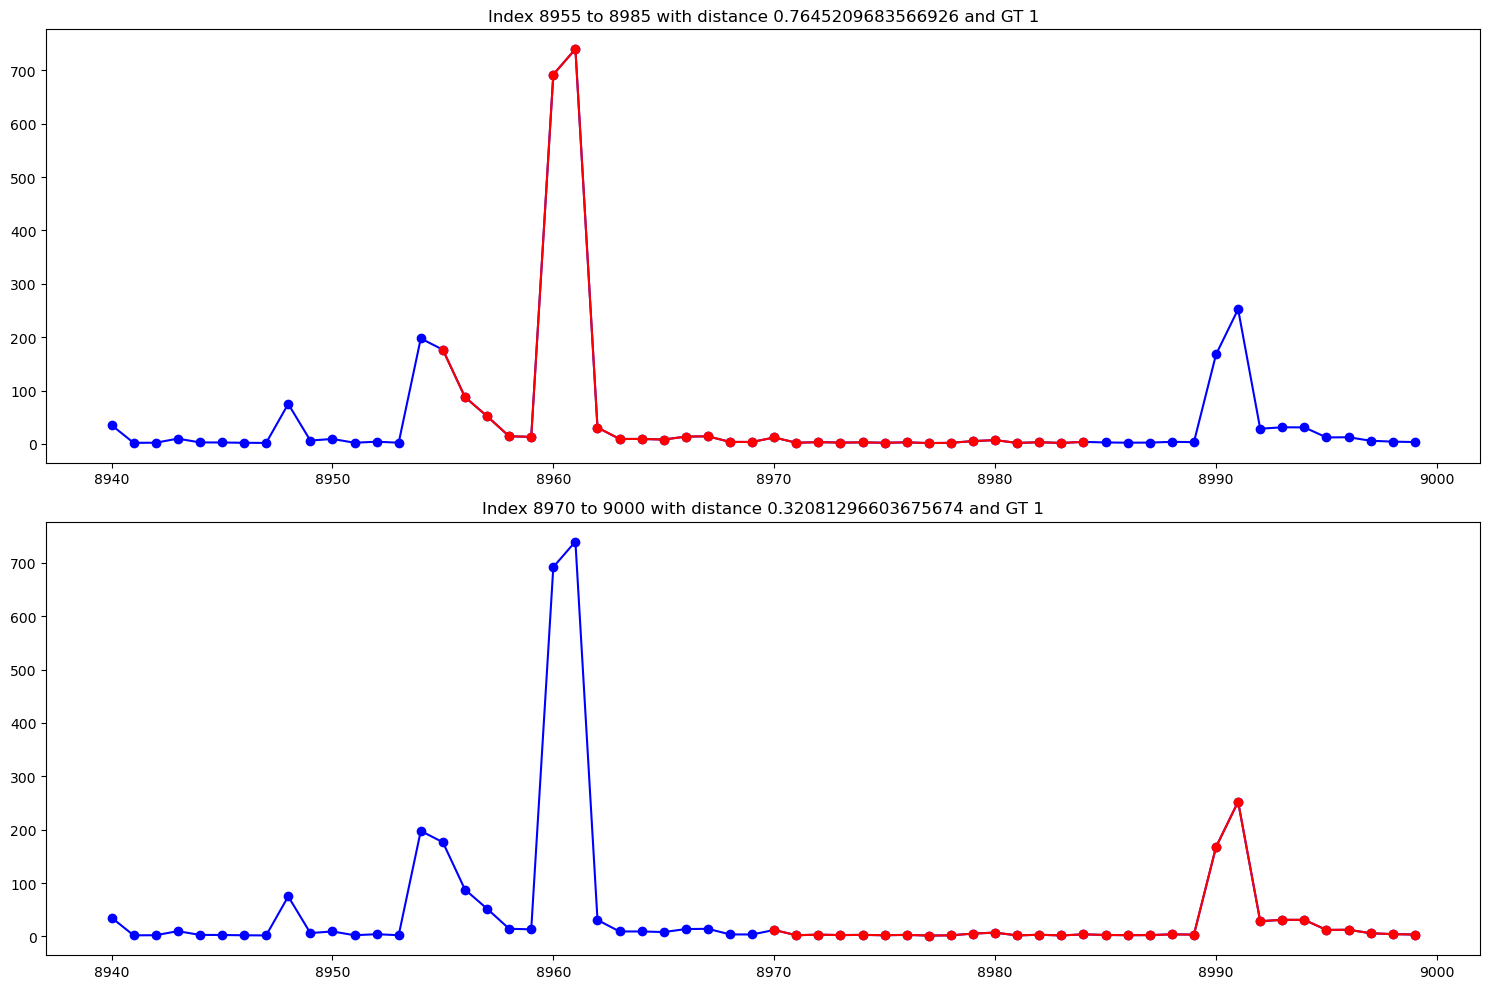

In [25]:
plt.figure(figsize=(15, 5 * num_plots))

for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(data[feature_name].iloc[start:end], marker='o', linestyle='-', color='b')
    
    cmp_start = (i+1) * step + start
    cmp_end = cmp_start + ref_size
    
    plt.plot(data[feature_name].iloc[cmp_start:cmp_end], marker='o', linestyle='-', color='r')
    
    gt_label = data_df['label'].iloc[index]
    plt.title(f'Index {cmp_start} to {cmp_end} with distance {data_df[str(i)].iloc[index]} and GT {gt_label}')
    
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

threshold = 0.1

In [27]:
eval_results = {}

for feature_name, data_df in js_distance.items():
    
    preds = data_df[['0', '1']].max(axis=1)
    preds_binary = preds > threshold
    
    true_labels = (data_df['label'] == 1)
    
    accuracy = accuracy_score(true_labels, preds_binary)
    recall = recall_score(true_labels, preds_binary, average='macro', zero_division=0)
    precision = precision_score(true_labels, preds_binary, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds_binary, average='macro', zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(true_labels, preds_binary).ravel()
    
    # Store the results in the dictionary
    eval_results[feature_name] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp,
        'true_negatives': tn
    }
    
    # print(f"Feature: {feature_name}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"Precision: {precision:.4f}")
    # print(f"F1 Score: {f1:.4f}")
    # print(f"False Positives: {fp}")
    # print(f"False Negatives: {fn}")
    # print(f"True Positives: {tp}")
    # print(f"True Negatives: {tn}\n")
    


results_df = pd.DataFrame(eval_results).T
average_metrics = results_df.mean()

# Print the averages
print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
print(f"Average Recall: {average_metrics['recall']:.4f}")
print(f"Average Precision: {average_metrics['precision']:.4f}")
print(f"Average F1 Score: {average_metrics['f1_score']:.4f}")
print(f"Average False Positives: {average_metrics['false_positives']:.4f}")
print(f"Average False Negatives: {average_metrics['false_negatives']:.4f}")
print(f"Average True Positives: {average_metrics['true_positives']:.4f}")
print(f"Average True Negatives: {average_metrics['true_negatives']:.4f}")

Average Accuracy: 0.7329
Average Recall: 0.7347
Average Precision: 0.7657
Average F1 Score: 0.7195
Average False Positives: 12.1667
Average False Negatives: 5.3333
Average True Positives: 28.8333
Average True Negatives: 19.0000


/tmp/ipykernel_115876/3384678529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette='viridis')
/tmp/ipykernel_115876/3384678529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette='viridis')
/tmp/ipykernel_115876/3384678529.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=metric, data=results_df, palette='viridis')
/tmp/ipykernel_115876/3384678529.py:10: FutureWarning: 

Passing `palette` without assignin

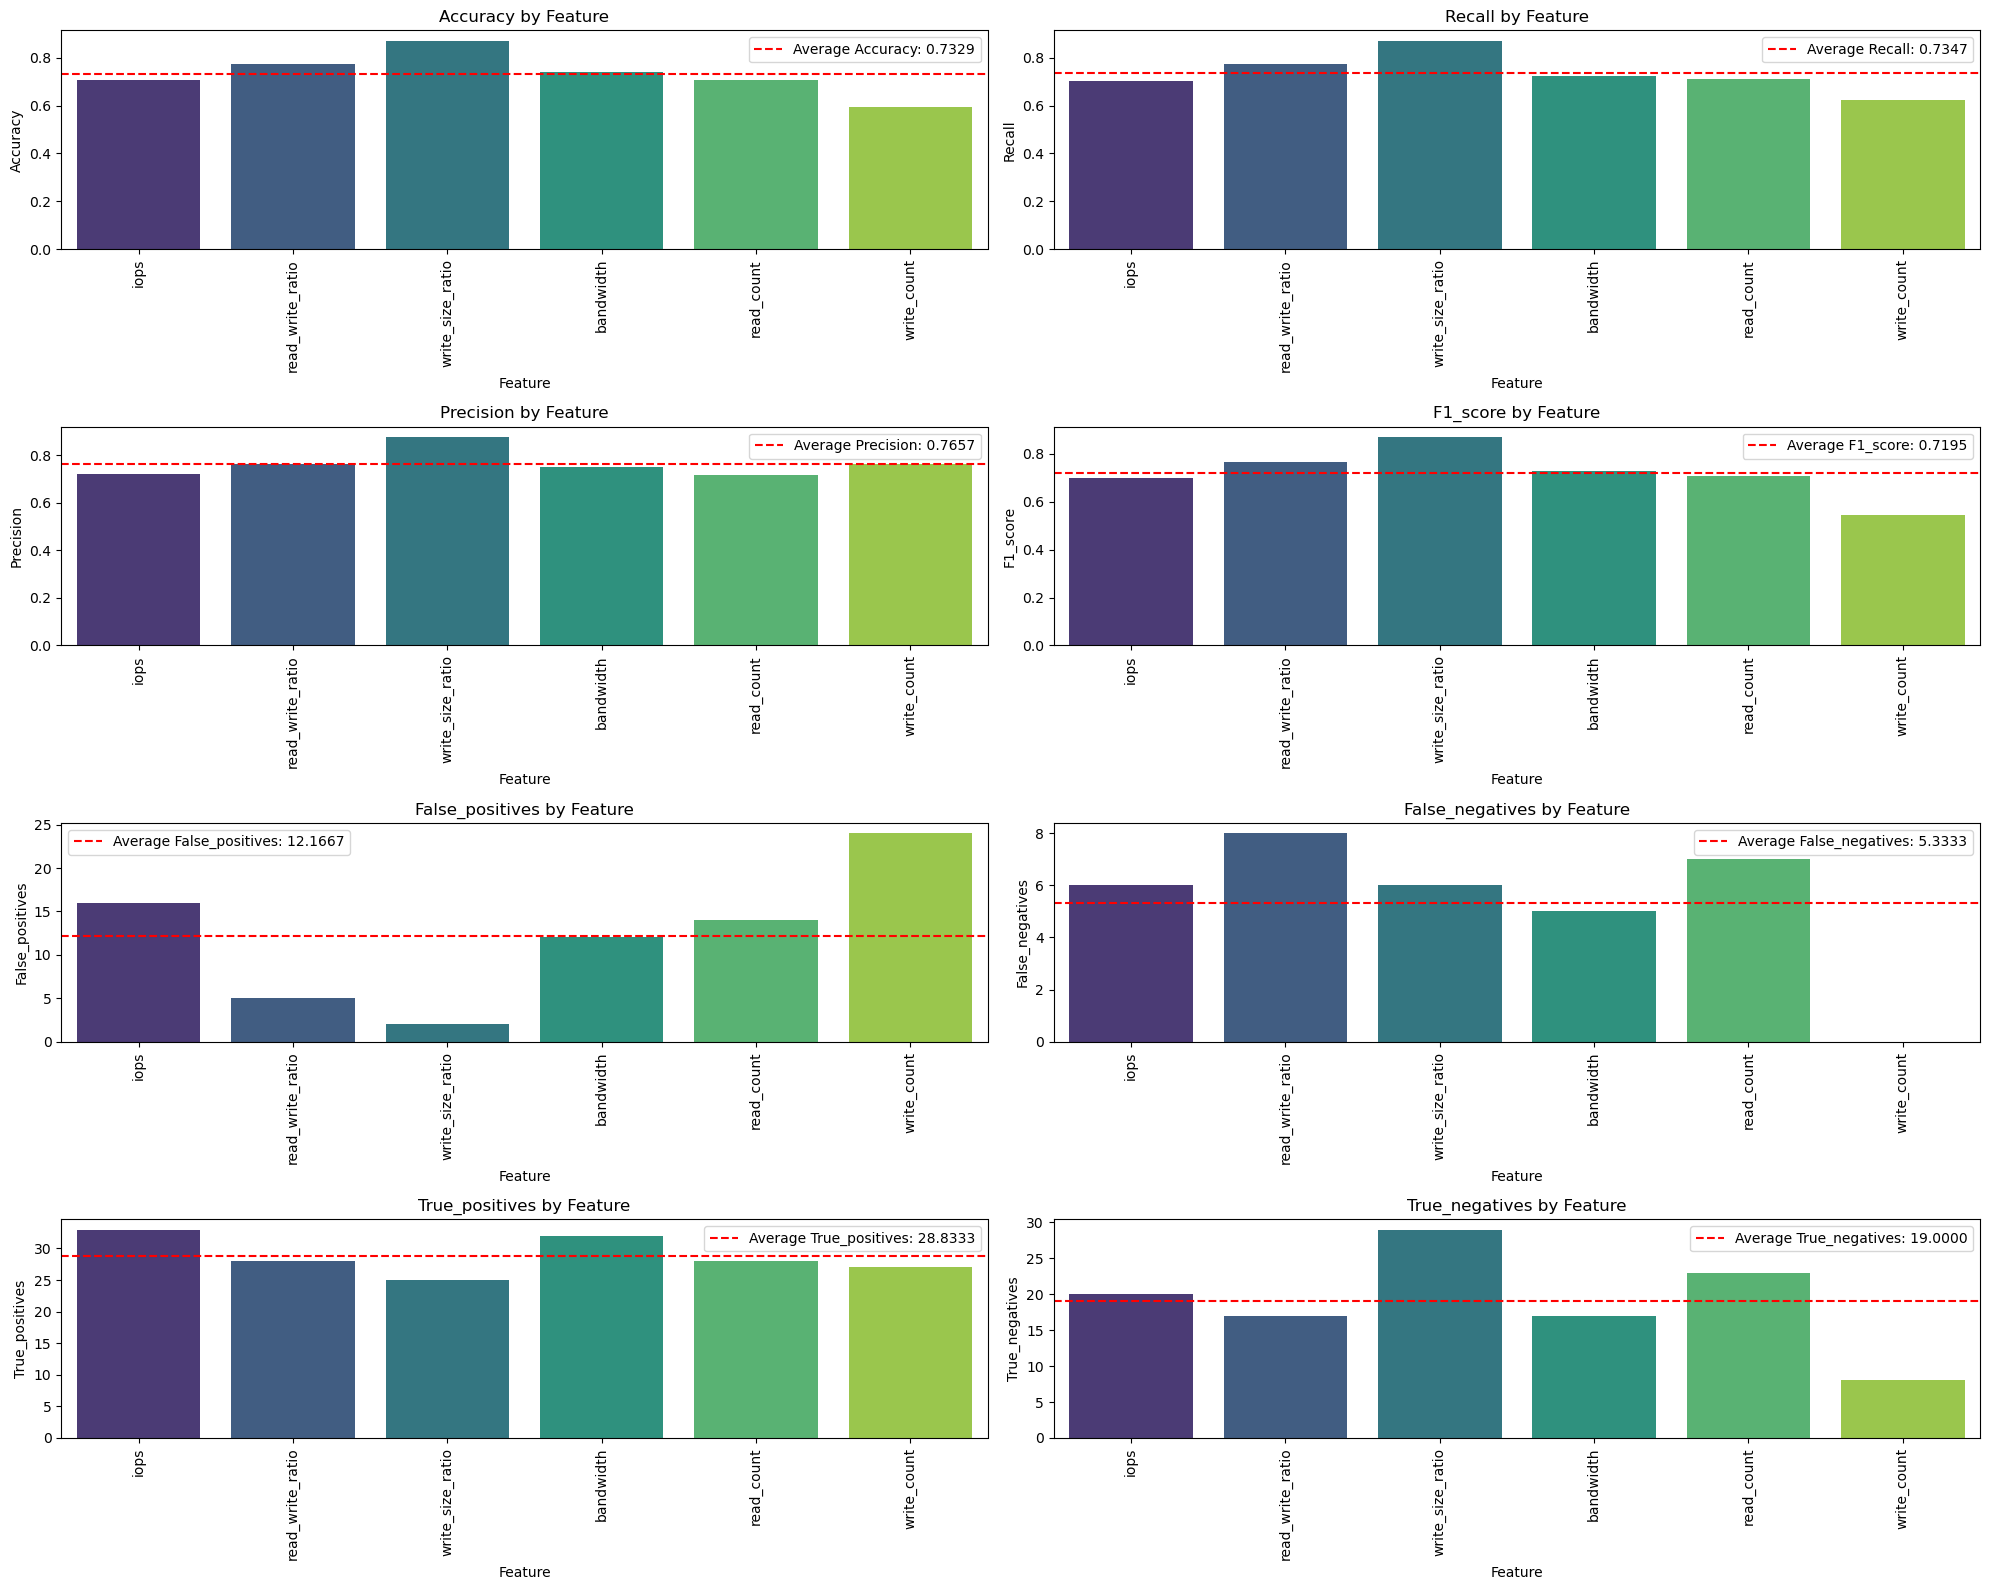

In [28]:
import seaborn as sns

metrics = ['accuracy', 'recall', 'precision', 'f1_score', 'false_positives', 'false_negatives', 'true_positives', 'true_negatives']

plt.figure(figsize=(20, 16))

# Plot each metric
for i, metric in enumerate(metrics, 1):
    plt.subplot(4, 2, i)
    sns.barplot(x=results_df.index, y=metric, data=results_df, palette='viridis')
    plt.axhline(y=average_metrics[metric], color='red', linestyle='--', label=f'Average {metric.capitalize()}: {average_metrics[metric]:.4f}')
    plt.title(f'{metric.capitalize()} by Feature')
    plt.xlabel('Feature')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=90)
    plt.legend()

# Show plots
plt.tight_layout()
plt.show()